In [1183]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

import warnings
warnings.filterwarnings("ignore")

## 参数选择

In [1184]:
experiment_id = 2

In [1185]:
choose_market = 0
emo_index = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'][choose_market]
market_address = ['个股分析_上证综合', '个股分析_沪深300', '个股分析_创业板'][choose_market]
experiment = ['Ours', 'BERT + DTW', 'BERT + Density', 'BERT + Features', 'BERT + Representations'][experiment_id]

ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering'
Emotion_Data_PATH = f'{ROOT_PATH}/data/Emotion_Data/Deep-learning/BERT'   # 情绪数据路径
Financial_Data_PATH = f'{ROOT_PATH}/data/Financial_Data' # 金融数据路径

## 数据预处理

In [1186]:
if experiment == 'Ours':
    # Ours
    cluster_data = pd.read_csv(f'/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/DTW_KMeans/个股分析/183/Deep-learning/Integrated_task/个股分析_高维情绪/clusters_results.csv', dtype={"Stkcd": str})
elif experiment == 'BERT + DTW':
    # BERT + DTW
    cluster_data = pd.read_csv(f'/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/DTW_KMeans/个股分析/183/Deep-learning/Separated_task/个股分析_上证综合/clusters_results.csv', dtype={"Stkcd": str})
elif experiment == 'BERT + Density':
    # BERT + Density
    cluster_data = pd.read_csv(f'/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/Other_Clusters/个股分析/基于密度的聚类/上证综合情绪值/clusters_results.csv', dtype={"Stkcd": str})
elif experiment == 'BERT + Features':
    # BERT + Features
    cluster_data = pd.read_csv(f'/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/Other_Clusters/个股分析/基于特征的聚类/上证综合情绪值/clusters_results.csv', dtype={"Stkcd": str})
elif experiment == 'BERT + Representations':
    # BERT + Representations
    cluster_data = pd.read_csv(f'/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/Other_Clusters/个股分析/基于表示的聚类/上证综合情绪值/clusters_results.csv', dtype={"Stkcd": str})

cluster_data.columns = ['股票编号', '聚类标签', '公司名称']
print(cluster_data.head())

     股票编号  聚类标签   公司名称
0  000002     0    万科A
1  000061    -1    农产品
2  000063     0   中兴通讯
3  000069    -1   华侨城A
4  000100     0  TCL科技


In [1187]:
from sklearn.cluster import KMeans
# 防止 BERT + Density 作弊 （原则上簇越多越好）
if experiment == 'BERT + Density':
    X = cluster_data[['聚类标签']].values
    kmeans = KMeans(n_clusters=3, random_state=42)
    new_labels = kmeans.fit_predict(X)
    
    cluster_data['聚类标签'] = new_labels
    print(cluster_data.head())

     股票编号  聚类标签   公司名称
0  000002     2    万科A
1  000061     0    农产品
2  000063     2   中兴通讯
3  000069     0   华侨城A
4  000100     2  TCL科技


In [1188]:
"""读取股吧个股的数据"""
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in file_list:
    file_path = os.path.join(Emotion_Data_PATH, file)
    df = pd.read_csv(file_path)
    stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
    
    # 提取每一行的日期和情绪值
    for _, row in df.iterrows():
        new_row = {
            '股票编号': stock_code,
            '日期': row['日期'],
            '上证综合情绪值': row['上证综合情绪值'],
            '沪深300情绪值': row['沪深300情绪值'],
            '创业板情绪值': row['创业板情绪值']
        }
        all_data.append(new_row)
        
guba_data = pd.DataFrame(all_data)
guba_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值
0,601933,2024-12-27,0.007,-0.044,-0.015
1,601933,2024-11-18,-0.155,-0.236,-0.354
2,601933,2024-11-17,0.001,0.022,0.004
3,601933,2024-11-17,-0.346,-0.337,-0.407
4,601933,2024-11-17,-0.247,-0.309,-0.358
...,...,...,...,...,...
495326,601919,2021-04-09,0.253,0.327,0.457
495327,601919,2021-04-09,-0.177,-0.190,-0.196
495328,601919,2021-04-08,0.218,0.194,0.167
495329,601919,2021-04-08,0.148,0.142,0.346


In [1189]:
"""读取股票回报率的数据"""
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

,股票编号,日期,交易量,收益率变化
0,000002,2021-06-01,60990961,-0.003745
1,000002,2021-06-02,85354506,0.006015
2,000002,2021-06-03,50594187,-0.003363
3,000002,2021-06-04,71422364,-0.012748
4,000002,2021-06-07,64745280,-0.014812
...,...,...,...,...
154877,688981,2024-11-20,58507495,-0.017071
154878,688981,2024-11-21,56197106,0.002358
154879,688981,2024-11-22,79240108,-0.050588
154880,688981,2024-11-25,76905909,-0.029402


In [1190]:
# 进行左连接，guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = merged_data.dropna()
merged_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
1,601933,2024-11-18,-0.155,-0.236,-0.354,310012824.0,-0.004608
11,601933,2024-11-15,-0.178,-0.191,-0.171,423271473.0,-0.064655
12,601933,2024-11-15,0.072,0.066,0.130,423271473.0,-0.064655
13,601933,2024-11-14,-0.019,0.027,0.068,372259052.0,-0.053061
14,601933,2024-11-14,-0.006,0.012,0.003,372259052.0,-0.053061
...,...,...,...,...,...,...,...
495148,601919,2021-06-01,0.265,0.327,0.476,268816321.0,0.045859
495149,601919,2021-06-01,-0.006,0.002,0.020,268816321.0,0.045859
495150,601919,2021-06-01,-0.034,-0.003,0.016,268816321.0,0.045859
495151,601919,2021-06-01,0.041,0.018,0.071,268816321.0,0.045859


In [1191]:
merged_data_total = pd.merge(merged_data, cluster_data, on='股票编号', how='left')
merged_data_total['日期'] = pd.to_datetime(merged_data_total['日期'])
merged_data_total = merged_data_total[(merged_data_total['日期'] > '2021-05-06') & (merged_data_total['日期'] < '2024-11-18')]
merged_data_total

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化,聚类标签,公司名称
1,601933,2024-11-15,-0.178,-0.191,-0.171,423271473.0,-0.064655,0,永辉超市
2,601933,2024-11-15,0.072,0.066,0.130,423271473.0,-0.064655,0,永辉超市
3,601933,2024-11-14,-0.019,0.027,0.068,372259052.0,-0.053061,0,永辉超市
4,601933,2024-11-14,-0.006,0.012,0.003,372259052.0,-0.053061,0,永辉超市
5,601933,2024-11-14,-0.051,-0.059,-0.004,372259052.0,-0.053061,0,永辉超市
...,...,...,...,...,...,...,...,...,...
391894,601919,2021-06-01,0.265,0.327,0.476,268816321.0,0.045859,0,中远海控
391895,601919,2021-06-01,-0.006,0.002,0.020,268816321.0,0.045859,0,中远海控
391896,601919,2021-06-01,-0.034,-0.003,0.016,268816321.0,0.045859,0,中远海控
391897,601919,2021-06-01,0.041,0.018,0.071,268816321.0,0.045859,0,中远海控


In [1192]:
# Step 1: 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# Step 2: 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    df_processed = pd.DataFrame()  # 用于存储结果
    for stock_code, stock_data in df.groupby('股票编号'):
        # 对每个股票编号内的数据进行标准化
        stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
        
        # 按日期汇总数据，同时保留股票编号
        stock_summary = stock_data.groupby('日期').agg({
            '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
            '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
            '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
            '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
            '交易量': 'mean',  # 交易量按日期求和
            '收益率变化': 'mean',  # 收益率变化按日期取均值
            '聚类标签': 'first', # 保留聚类标签（在同一日期内它是相同的，使用 'first'）
            '公司名称': 'first', # 保留公司名称（在同一日期内它是相同的，使用 'first'）
        }).reset_index(drop=False)
        
        # 合并每个股票的汇总数据
        df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
        df_processed = df_processed.sort_values(by=['股票编号', '日期'], ascending=[True, True])
    return df_processed

# 调用处理函数
final_data = process_data(merged_data_total)

final_data

,日期,股票编号,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化,聚类标签,公司名称
0,2021-06-01,000002,0.316338,0.267833,0.280789,60990961.0,-0.003745,2,万科A
1,2021-06-08,000002,0.347227,0.287914,0.300312,44676494.0,0.004626,2,万科A
2,2021-06-10,000002,0.325725,0.281754,0.289027,53800776.0,-0.010035,2,万科A
3,2021-06-11,000002,0.285945,0.224180,0.235237,75853738.0,-0.014035,2,万科A
4,2021-06-15,000002,0.314849,0.268572,0.283593,89915501.0,-0.020957,2,万科A
...,...,...,...,...,...,...,...,...,...
85668,2024-11-11,688981,0.347604,0.325915,0.231295,138069018.0,0.046660,0,中芯国际
85669,2024-11-12,688981,0.360433,0.328320,0.235728,108866759.0,-0.036864,0,中芯国际
85670,2024-11-13,688981,0.269057,0.242652,0.142033,80759477.0,-0.019484,0,中芯国际
85671,2024-11-14,688981,0.286646,0.247683,0.160005,76194102.0,-0.022897,0,中芯国际


In [1193]:
# 按【聚类标签】和【日期】分组，计算：
# - 【上证综合情绪值、沪深300情绪值、创业板情绪值、收益率变化】的均值
# - 【交易量】的总和
different_asset_data = final_data.groupby(["聚类标签", "日期"]).agg({
    "上证综合情绪值": "mean",
    "沪深300情绪值": "mean",
    "创业板情绪值": "mean",
    "收益率变化": "mean",
    "交易量": "sum"
}).reset_index()

# 查看结果
different_asset_data

,聚类标签,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,收益率变化,交易量
0,0,2021-06-01,0.171634,0.116629,0.119515,0.002399,1.550897e+09
1,0,2021-06-02,0.196143,0.149943,0.166946,-0.014966,1.817553e+09
2,0,2021-06-03,0.173875,0.130592,0.140460,-0.010338,1.666600e+09
3,0,2021-06-04,0.181232,0.147975,0.152100,0.006379,1.573735e+09
4,0,2021-06-07,0.179354,0.132125,0.155248,0.007525,1.326151e+09
...,...,...,...,...,...,...,...
2515,2,2024-11-11,0.272636,0.222430,0.231508,0.020108,8.131447e+09
2516,2,2024-11-12,0.239141,0.188079,0.196272,-0.006676,9.708120e+09
2517,2,2024-11-13,0.254128,0.203390,0.210918,0.003765,7.546933e+09
2518,2,2024-11-14,0.224388,0.172199,0.178627,-0.027811,6.882748e+09


## 基于投资学理论的投资组合

In [1194]:
df = different_asset_data.copy()
df.set_index("日期", inplace=True)

# 按聚类标签分组
clusters = df["聚类标签"].unique()
cluster_returns = {c: df[df["聚类标签"] == c]["收益率变化"] for c in clusters}

# 计算每个聚类的均值、波动性
cluster_stats = {
    c: {"Mean Return": cluster_returns[c].mean(), "Volatility": cluster_returns[c].std()}
    for c in clusters
}

# 转换为 DataFrame
stats_df = pd.DataFrame(cluster_stats).T
os.makedirs('长期投资/tables/资产收益统计',exist_ok=True)
stats_df.to_csv(f'长期投资/tables/资产收益统计/{experiment}')
stats_df

,Mean Return,Volatility
0,0.000723,0.012688
1,-0.000038,0.014422
2,0.000194,0.013499


In [1195]:
import cvxpy as cp

# 计算协方差矩阵
returns_matrix = pd.DataFrame(cluster_returns)
cov_matrix = returns_matrix.cov()

# 变量：投资组合权重
w = cp.Variable(len(clusters))

# 目标函数：最小化风险（方差）
risk_aversion = 0.2  # 风险厌恶系数

expected_returns = np.array([cluster_stats[c]["Mean Return"] for c in clusters])

objective = cp.Minimize(cp.quad_form(w, cov_matrix) - risk_aversion * expected_returns.T @ w)

# # 约束条件：总权重为1，且能做空 50 %
constraints = [cp.sum(w) == 1, w >= -0.5]

# 求解优化问题
problem = cp.Problem(objective, constraints)
problem.solve()

# 输出最优权重
optimal_weights = w.value
for c, weight in zip(clusters, optimal_weights):
    print(f"Cluster {c}: {weight:.4f}")

# 构建结果 DataFrame
shareholding_ratio = pd.DataFrame({
    "Cluster": clusters,
    "Optimal Weight": optimal_weights
})

os.makedirs('长期投资/tables/最优持有权重',exist_ok=True)
shareholding_ratio.to_csv(f'长期投资/tables/最优持有权重/{experiment}')

Cluster 0: 1.8095
Cluster 1: -0.3095
Cluster 2: -0.5000


In [1196]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# 确保数据按时间排序
df = df.sort_index()

# 获取所有聚类标签
clusters = df["聚类标签"].unique()

# 设置测试集时间段（1年、2年、全部）
test_periods = [365, 730]  # 最后一年、最后两年
results = {}

for period in test_periods:
    # 计算测试集起始时间
    test_start_date = df.index[-1] - pd.Timedelta(days=period)
    
    # 选取测试集数据
    test_data = df.loc[df.index >= test_start_date]
    
    # 训练集是所有之前的数据
    train_data = df.loc[df.index < test_start_date]

    # 计算训练集的均值和协方差
    train_returns = train_data.pivot(columns="聚类标签", values="收益率变化").dropna()
    
    if train_returns.empty:  # 如果训练数据为空，跳过
        continue
    
    mean_returns = train_returns.mean().values.reshape(-1, 1)  # 确保是 (n,1) 形状
    cov_matrix = train_returns.cov().values  # 协方差矩阵

    # 变量: 投资组合权重 (列向量)
    w = cp.Variable((len(clusters), 1))

    # 目标函数: 最小化风险 - 预期收益
    objective = cp.Minimize(cp.quad_form(w, cov_matrix) - risk_aversion * mean_returns.T @ w)

    # 求解优化问题
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is None:  # 若求解失败，则跳过
        continue

    # 计算测试集的组合收益
    test_returns = test_data.pivot(columns="聚类标签", values="收益率变化").dropna()

    if test_returns.empty:  # 若测试数据为空，则跳过
        continue

    portfolio_returns = (test_returns * w.value.flatten()).sum(axis=1)  # 计算每日收益
    cumulative_returns = (1 + portfolio_returns).cumprod()  # 计算累计收益

    # 计算绩效指标
    sharpe_ratio = (portfolio_returns.mean() - 0.02 / 252) / portfolio_returns.std()
    volatility = portfolio_returns.std()

    results[f"{period}D"] = {
        "Cumulative Return": cumulative_returns.iloc[-1],
        "Sharpe Ratio": sharpe_ratio,
        "Volatility": volatility,
    }

# === 计算“全部时段”的投资组合 ===
train_returns_all = df.pivot(columns="聚类标签", values="收益率变化").dropna()

if not train_returns_all.empty:
    mean_returns_all = train_returns_all.mean().values.reshape(-1, 1)
    cov_matrix_all = train_returns_all.cov().values

    # 变量: 投资组合权重
    w_all = cp.Variable((len(clusters), 1))

    # 目标函数
    objective_all = cp.Minimize(cp.quad_form(w_all, cov_matrix_all) - risk_aversion * mean_returns_all.T @ w_all)

    # 约束条件
    constraints_all = [cp.sum(w_all) == 1]  # 允许做空

    # 求解优化问题
    problem_all = cp.Problem(objective_all, constraints_all)
    problem_all.solve()
    
    
    if w_all.value is not None:
        # 计算所有时间段的组合收益
        portfolio_returns_all = (train_returns_all * w_all.value.flatten()).sum(axis=1)
        cumulative_returns_all = (1 + portfolio_returns_all).cumprod()

        # 计算绩效指标
        sharpe_ratio_all = (portfolio_returns_all.mean() - 0.02 / 252) / portfolio_returns_all.std()
        volatility_all = portfolio_returns_all.std()
        
        # 记录到结果
        results["All Time"] = {
            "Cumulative Return": cumulative_returns_all.iloc[-1],
            "Sharpe Ratio": sharpe_ratio_all,
            "Volatility": volatility_all,
        }

# === 输出回测结果 ===
results_df = pd.DataFrame(results).T
os.makedirs('长期投资/tables/累计收益',exist_ok=True)
results_df.to_csv(f'长期投资/tables/累计收益/{experiment}')
results_df


,Cumulative Return,Sharpe Ratio,Volatility
365D,1.334727,0.113109,0.010315
730D,1.398866,0.128059,0.004879
All Time,2.980224,0.085881,0.015624


In [1197]:
results.keys()

dict_keys(['365D', '730D', 'All Time'])

In [1198]:
index_returns_df = pd.read_csv(
    "/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/data/Financial_Data/指数变化率.csv",
    parse_dates=["Idxtrd01"],
    dtype={"Indexcd": str}
)

index_returns_df.columns = ['交易所指数编号', '交易日期', '收益率变化']
sz300_df = index_returns_df[index_returns_df["交易所指数编号"] == "000001"].copy()

# 筛选起始日期为2021-06-01及之后的数据
sz300_df = sz300_df[sz300_df["交易日期"] >= pd.Timestamp("2021-06-01")].copy()

# 初始化累计收益列，第一天累计收益为0
sz300_df = sz300_df.sort_values("交易日期").reset_index(drop=True)
sz300_df.loc[:, "累计收益"] = 0.0

# 计算累计收益，Idxtrd08是日收益率(百分比，如0.4716%)
# 先转换为小数形式，方便计算
daily_returns = sz300_df["收益率变化"] / 100

# 累积收益公式：(1 + r1) * (1 + r2) * ... - 1
sz300_df.loc[:, "累计收益"] = (1 + daily_returns).cumprod() - 1

# 显示结果
sz300_df[["交易日期", "收益率变化", "累计收益"]]

,交易日期,收益率变化,累计收益
0,2021-06-01,0.2555,0.002555
1,2021-06-02,-0.7608,-0.005072
2,2021-06-03,-0.3593,-0.008647
3,2021-06-04,0.2130,-0.006536
4,2021-06-07,0.2143,-0.004407
...,...,...,...
845,2024-11-25,-0.1050,-0.097274
846,2024-11-26,-0.1226,-0.098381
847,2024-11-27,1.5345,-0.084545
848,2024-11-28,-0.4254,-0.088440


In [1199]:
df

,聚类标签,上证综合情绪值,沪深300情绪值,创业板情绪值,收益率变化,交易量
日期,,,,,,
2021-06-01,0,0.171634,0.116629,0.119515,0.002399,1.550897e+09
2021-06-01,1,0.097765,0.038933,0.063323,0.004749,5.992749e+08
2021-06-01,2,0.252847,0.207560,0.221707,0.006233,2.691176e+09
2021-06-02,0,0.196143,0.149943,0.166946,-0.014966,1.817553e+09
2021-06-02,1,0.095871,0.008569,0.024010,-0.012382,3.290043e+08
...,...,...,...,...,...,...
2024-11-14,0,0.151714,0.100566,0.118324,-0.025988,8.029549e+09
2024-11-14,1,0.026118,-0.039392,-0.006937,-0.012900,7.561287e+08
2024-11-15,1,0.009261,-0.058482,-0.044112,-0.002048,7.064660e+08


In [1200]:
# market_returns = df.groupby(df.index)["收益率变化"].mean()
# market_cumulative_returns = (1 + market_returns).cumprod()
# market_cumulative_returns

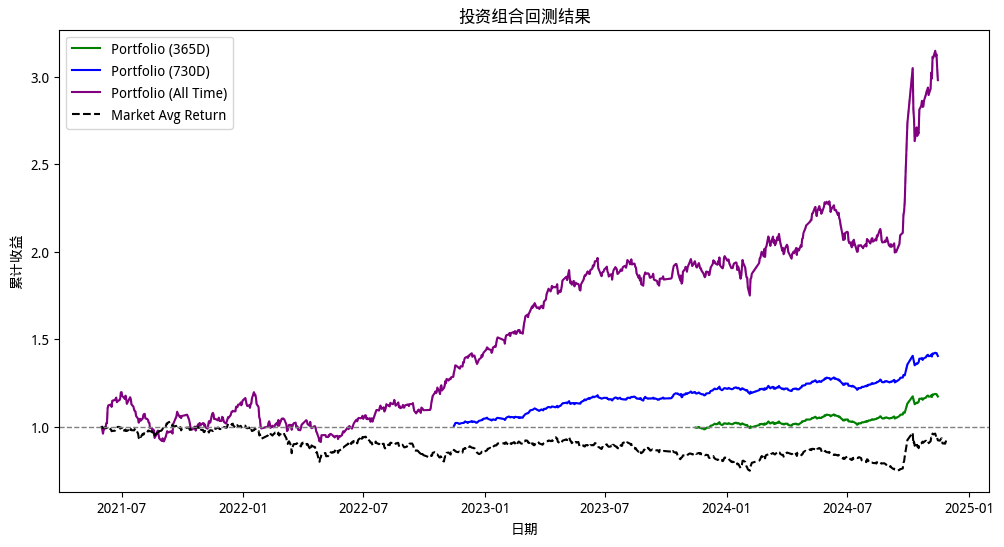

In [1201]:
import matplotlib.pyplot as plt
import pandas as pd

# 定义颜色映射
color_map = {
    "365D": "green",
    "730D": "blue",
    "All Time": "purple"  # 全部时段的颜色
}

plt.figure(figsize=(12, 6))

for period, result in results.items():
    if period == "All Time":
        test_start_date = df.index[0]  # 从数据的第一天开始
    elif period == "365D":
        test_start_date = df.index[-1] - pd.DateOffset(years=1)  # 计算最后一年的起始日期
    elif period == "730D":
        test_start_date = df.index[-1] - pd.DateOffset(years=2)  # 计算最后两年的起始日期
    
    test_data = df.loc[df.index >= test_start_date]  # 获取测试数据
    if test_data.empty:
        continue

    # 获取收益率
    test_returns = test_data.pivot(columns="聚类标签", values="收益率变化").dropna()

    if test_returns.empty:
        continue

    # 计算组合收益
    if period == "All Time":
        portfolio_returns = (test_returns * w_all.value.flatten()).sum(axis=1)  # 使用全部时段的权重
    else:
        portfolio_returns = (test_returns * w.value.flatten()).sum(axis=1)  # 计算每日收益

    # 计算累计收益
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # 插值缺失的数据
    cumulative_returns_interp = cumulative_returns.interpolate(method='linear')

    # 获取当前测试期的颜色
    color = color_map.get(period, "gray")  # 如果 period 不在 color_map 里，就用灰色

    # 可视化：实线和虚线
    plt.plot(cumulative_returns.index, cumulative_returns, label=f"Portfolio ({period})", linestyle='-', color=color)
    plt.plot(cumulative_returns_interp.index, cumulative_returns_interp, linestyle='--', color=color, alpha=0.3)

# 绘制大盘收益（黑色虚线）
plt.plot(sz300_df["交易日期"], sz300_df["累计收益"]+1, linestyle='--', color='black', label="Market Avg Return")

plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.title("投资组合回测结果")
plt.xlabel("日期")
plt.ylabel("累计收益")
plt.legend()
os.makedirs('长期投资/charts/金融学理论投资组合', exist_ok=True)
plt.savefig(f'长期投资/charts/金融学理论投资组合/{experiment}-投资组合回测结果.png')
plt.show()


In [1202]:
import seaborn as sns
from scipy.stats import norm

MC_SIMULATIONS = 30  # 模拟次数
CONFIDENCE = 0.95      # 置信水平

def monte_carlo_confidence(train_returns, test_returns, risk_aversion, clusters):
    portfolio_returns_mc = []
    
    for _ in range(MC_SIMULATIONS):
        # Bootstrap重采样训练集（按行采样）
        boot_sample = train_returns.sample(n=len(train_returns), replace=True)
        
        # 计算均值和协方差
        mean_boot = boot_sample.mean().values.reshape(-1, 1)
        cov_boot = boot_sample.cov().values
        
        # 定义优化问题
        w_mc = cp.Variable((len(clusters), 1))
        obj = cp.Minimize(cp.quad_form(w_mc, cov_boot) - risk_aversion * mean_boot.T @ w_mc)
        cons = [cp.sum(w_mc) == 1, w_mc >= -0.5]
        prob = cp.Problem(obj, cons)
        try:
            prob.solve()
            if w_mc.value is not None:
                port_ret = (test_returns * w_mc.value.flatten()).sum(axis=1)
                cum_ret = (1 + port_ret).prod()  # 只保留最后收益
                portfolio_returns_mc.append(cum_ret)
        except:
            continue  # 某些样本不收敛，跳过

    # 计算置信区间
    if len(portfolio_returns_mc) > 10:
        lower = np.percentile(portfolio_returns_mc, (1 - CONFIDENCE) / 2 * 100)
        upper = np.percentile(portfolio_returns_mc, (1 + CONFIDENCE) / 2 * 100)
        mean = np.mean(portfolio_returns_mc)
        return mean, lower, upper
    else:
        return None, None, None
        
# 添加蒙特卡洛置信度
mc_mean, mc_lower, mc_upper = monte_carlo_confidence(train_returns, test_returns, risk_aversion, clusters)

results[f"{period}D"] = {
    "Cumulative Return": cumulative_returns.iloc[-1],
    "Sharpe Ratio": sharpe_ratio,
    "Volatility": volatility,
    "MC Mean Return": mc_mean,
    "MC 95% CI Lower": mc_lower,
    "MC 95% CI Upper": mc_upper,
}

In [1203]:
confidence_level_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Test Period"})
os.makedirs('长期投资/tables/置信度检验',exist_ok=True)
confidence_level_df.to_csv(f'长期投资/tables/置信度检验/{experiment}')
confidence_level_df.head()

,Test Period,Cumulative Return,Sharpe Ratio,Volatility,MC Mean Return,MC 95% CI Lower,MC 95% CI Upper
0,365D,1.334727,0.113109,0.010315,NaN,NaN,NaN
1,730D,1.398866,0.128059,0.004879,NaN,NaN,NaN
2,All Time,2.980224,0.085881,0.015624,NaN,NaN,NaN
3,All TimeD,2.980224,0.128059,0.004879,2.107238,1.333195,2.846674


## 基于机器学习的短线投资

In [1204]:
df = final_data.copy()
df

,日期,股票编号,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化,聚类标签,公司名称
0,2021-06-01,000002,0.316338,0.267833,0.280789,60990961.0,-0.003745,2,万科A
1,2021-06-08,000002,0.347227,0.287914,0.300312,44676494.0,0.004626,2,万科A
2,2021-06-10,000002,0.325725,0.281754,0.289027,53800776.0,-0.010035,2,万科A
3,2021-06-11,000002,0.285945,0.224180,0.235237,75853738.0,-0.014035,2,万科A
4,2021-06-15,000002,0.314849,0.268572,0.283593,89915501.0,-0.020957,2,万科A
...,...,...,...,...,...,...,...,...,...
85668,2024-11-11,688981,0.347604,0.325915,0.231295,138069018.0,0.046660,0,中芯国际
85669,2024-11-12,688981,0.360433,0.328320,0.235728,108866759.0,-0.036864,0,中芯国际
85670,2024-11-13,688981,0.269057,0.242652,0.142033,80759477.0,-0.019484,0,中芯国际
85671,2024-11-14,688981,0.286646,0.247683,0.160005,76194102.0,-0.022897,0,中芯国际


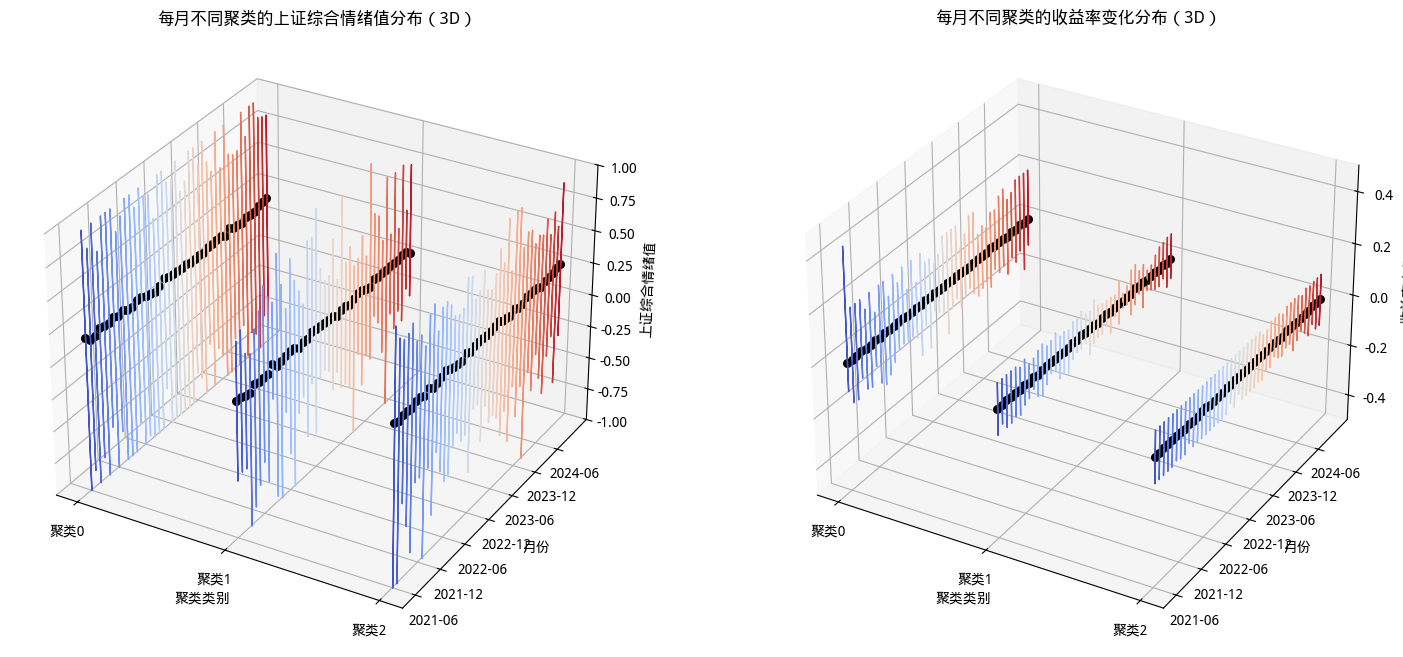

In [1205]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 确保日期列为 datetime 类型
df["日期"] = pd.to_datetime(df["日期"])

# 提取"年-月"作为新列（用于分组）
df["年月"] = df["日期"].dt.to_period("M")

# 获取唯一的月份列表 & 聚类标签
unique_months = sorted(df["年月"].unique())
unique_clusters = sorted(df["聚类标签"].unique())

# 选择每 6 个月显示一次
tick_months = unique_months[::6]

# 创建颜色映射
colors = sns.color_palette("coolwarm", len(unique_months))

# 创建画布
fig = plt.figure(figsize=(18, 8))

# 🎨 1. 上证综合情绪值的三维箱式图
ax1 = fig.add_subplot(121, projection="3d")

for i, month in enumerate(unique_months):
    for j, cluster in enumerate(unique_clusters):
        # 选取对应月份 & 聚类的数据
        subset = df[(df["年月"] == month) & (df["聚类标签"] == cluster)]["上证综合情绪值"]
        
        if len(subset) > 0:
            q1, q2, q3 = np.percentile(subset, [25, 50, 75])
            whisker_low, whisker_high = np.min(subset), np.max(subset)
            box = [[(j, i, whisker_low), (j, i, q1), (j, i, q3), (j, i, whisker_high)]]
            ax1.add_collection3d(Poly3DCollection(box, color=colors[i], alpha=0.6))
            ax1.scatter(j, i, q2, color="black", s=30)  # 中位数

ax1.set_xlabel("聚类类别")
ax1.set_ylabel("月份")
ax1.set_zlabel("上证综合情绪值")
ax1.set_title("每月不同聚类的上证综合情绪值分布（3D）")

# 设置 X 轴刻度（聚类类别）
ax1.set_xticks(unique_clusters)
ax1.set_xticklabels([f"聚类{c}" for c in unique_clusters])

# 设置 Y 轴刻度（时间，每 6 个月显示一次）
ax1.set_yticks([unique_months.index(m) for m in tick_months])
ax1.set_yticklabels([str(m) for m in tick_months])

# 设置 Z 轴范围
ax1.set_zlim(-1, 1)


# 🎨 2. 收益率的三维箱式图
ax2 = fig.add_subplot(122, projection="3d")

for i, month in enumerate(unique_months):
    for j, cluster in enumerate(unique_clusters):
        # 选取对应月份 & 聚类的数据
        subset = df[(df["年月"] == month) & (df["聚类标签"] == cluster)]["收益率变化"]
        
        if len(subset) > 0:
            q1, q2, q3 = np.percentile(subset, [25, 50, 75])
            whisker_low, whisker_high = np.min(subset), np.max(subset)
            box = [[(j, i, whisker_low), (j, i, q1), (j, i, q3), (j, i, whisker_high)]]
            ax2.add_collection3d(Poly3DCollection(box, color=colors[i], alpha=0.6))
            ax2.scatter(j, i, q2, color="black", s=30)  # 中位数

ax2.set_xlabel("聚类类别")
ax2.set_ylabel("月份")
ax2.set_zlabel("收益率变化")
ax2.set_title("每月不同聚类的收益率变化分布（3D）")

# 设置 X 轴刻度（聚类类别）
ax2.set_xticks(unique_clusters)
ax2.set_xticklabels([f"聚类{c}" for c in unique_clusters])

# 设置 Y 轴刻度（时间，每 6 个月显示一次）
ax2.set_yticks([unique_months.index(m) for m in tick_months])
ax2.set_yticklabels([str(m) for m in tick_months])

# 设置 Z 轴范围
ax2.set_zlim(-0.5, 0.5)

# 调整子图间距
plt.tight_layout()
plt.show()


In [1206]:
df = final_data[['日期', '股票编号', '上证综合情绪值', '收益率变化', '聚类标签']].copy()
df

,日期,股票编号,上证综合情绪值,收益率变化,聚类标签
0,2021-06-01,000002,0.316338,-0.003745,2
1,2021-06-08,000002,0.347227,0.004626,2
2,2021-06-10,000002,0.325725,-0.010035,2
3,2021-06-11,000002,0.285945,-0.014035,2
4,2021-06-15,000002,0.314849,-0.020957,2
...,...,...,...,...,...
85668,2024-11-11,688981,0.347604,0.046660,0
85669,2024-11-12,688981,0.360433,-0.036864,0
85670,2024-11-13,688981,0.269057,-0.019484,0
85671,2024-11-14,688981,0.286646,-0.022897,0


In [1207]:
df['日期'] = pd.to_datetime(df['日期'])

# 按照日期和聚类标签分组，计算每组的情绪值均值、情绪值方差、收益率均值、收益率方差
result = df.groupby(['日期', '聚类标签']).agg(
    情绪值均值=('上证综合情绪值', 'mean'),
    情绪值方差=('上证综合情绪值', 'var'),
    收益率均值=('收益率变化', 'mean'),
    收益率方差=('收益率变化', 'var')
).reset_index()

# 查看处理后的数据
result

,日期,聚类标签,情绪值均值,情绪值方差,收益率均值,收益率方差
0,2021-06-01,0,0.171634,0.046488,0.002399,0.000437
1,2021-06-01,1,0.097765,0.011749,0.004749,0.000172
2,2021-06-01,2,0.252847,0.016586,0.006233,0.000396
3,2021-06-02,0,0.196143,0.060624,-0.014966,0.000713
4,2021-06-02,1,0.095871,0.003025,-0.012382,0.000214
...,...,...,...,...,...,...
2515,2024-11-14,1,0.026118,0.034398,-0.012900,0.000247
2516,2024-11-14,2,0.224388,0.026125,-0.027811,0.000613
2517,2024-11-15,0,0.155916,0.048159,-0.019894,0.000940
2518,2024-11-15,1,0.009261,0.008520,-0.002048,0.000630


In [1208]:
from hmmlearn import hmm
import numpy as np
import pandas as pd
import csv
import os

# 初始资产配置（可忽略，后面会动态计算）
asset_proportion = [0.33, 0.33, 0.34]
cumulative_income = 0

# 获取所有日期（升序）
dates = sorted(result["日期"].unique())

def calculate_sharpe_ratio(mean_return, variance, risk_free_rate=0.02):
    risk = np.sqrt(abs(variance))
    return (mean_return - risk_free_rate) / risk if risk != 0 else 1e-13

def fit_multivariate_hmm(data_array, n_states=2):
    """
    data_array: (n_samples, n_features)，如[情绪值均值, 收益率均值]
    返回：最后一天状态索引，状态对应收益率均值列表
    """
    if data_array.shape[0] < 50:
        return None, None

    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100, random_state=42)
    model.fit(data_array)

    hidden_states = model.predict(data_array)
    last_state = hidden_states[-1]

    state_means = []
    for i in range(n_states):
        # 取该状态下收益率均值的平均（收益率均值为第2列）
        state_data = data_array[hidden_states == i, 1]
        mean_val = state_data.mean() if len(state_data) > 0 else 0
        state_means.append(mean_val)

    return last_state, state_means

os.makedirs('长期投资/cumulative_income', exist_ok=True)

with open(f'长期投资/cumulative_income/{experiment}.csv', mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["日期", "累计收益", "当日投资组合"])
    writer.writeheader()

    for i in range(15, len(dates)-15):  # 根据你的策略区间
        today = dates[i]
        yesterday = dates[i - 1]

        # 取昨天之前所有历史数据
        hist = result[result["日期"] <= yesterday]
        unique_clusters = hist["聚类标签"].unique()

        predicted_returns = []
        predicted_variances = []

        for cluster in unique_clusters:
            cd = hist[hist["聚类标签"] == cluster]
            if len(cd) > 30:
                cd = cd[-30:]  # 只取最近30天数据

            # 取多变量序列：[情绪值均值, 收益率均值]
            data_array = cd.set_index("日期")[["情绪值均值", "收益率均值"]].dropna().values

            state, means = fit_multivariate_hmm(data_array, n_states=2)

            if state is None or means is None:
                pr_mean = 0
            else:
                pr_mean = means[state]

            pr_var = cd["收益率均值"].var() if not cd["收益率均值"].empty else 0

            predicted_returns.append(pr_mean)
            predicted_variances.append(pr_var)

        # 用夏普比率计算权重
        sharpe_list = [calculate_sharpe_ratio(mu, var) for mu, var in zip(predicted_returns, predicted_variances)]
        total_s = sum(sharpe_list) or 1e-13
        weights = np.array(sharpe_list) / total_s

        # 限制最小权重，归一化
        weights = np.clip(weights, -0.5, None)
        weights = weights / weights.sum()

        asset_proportion = weights.tolist()

        # 今天真实收益率
        td = result[result["日期"] == today]
        actual_returns = []
        for cluster in unique_clusters:
            ret_vals = td[td["聚类标签"] == cluster]["收益率均值"].values
            actual_returns.append(ret_vals[0] if len(ret_vals) > 0 else 0)

        day_income = np.dot(asset_proportion, actual_returns)
        cumulative_income += day_income

        writer.writerow({
            "日期": today,
            "累计收益": cumulative_income,
            "当日投资组合": str(asset_proportion)
        })

        print(f"日期: {today}, 投资组合: {asset_proportion}, 累计收益: {cumulative_income}")

print(f"最终累计收益: {cumulative_income}")


日期: 2021-06-23 00:00:00, 投资组合: [0.3198686500767794, 0.27558593906228596, 0.40454541086093476], 累计收益: 0.012724530669598636
日期: 2021-06-24 00:00:00, 投资组合: [0.33115449058360796, 0.2827140675492209, 0.38613144186717124], 累计收益: 0.012596855887107478
日期: 2021-06-25 00:00:00, 投资组合: [0.3269722155761872, 0.2832270552399212, 0.3898007291838916], 累计收益: 0.02822808670366769
日期: 2021-06-28 00:00:00, 投资组合: [0.3391283008090989, 0.2673520504762364, 0.39351964871466477], 累计收益: 0.032788240751316526
日期: 2021-06-29 00:00:00, 投资组合: [0.3403367951067285, 0.2649467401131898, 0.39471646478008166], 累计收益: 0.021297677660674294
日期: 2021-06-30 00:00:00, 投资组合: [0.3463562837587214, 0.26712179968925576, 0.38652191655202284], 累计收益: 0.02985502876733301
日期: 2021-07-01 00:00:00, 投资组合: [0.3415572335593444, 0.27044744982449176, 0.38799531661616393], 累计收益: 0.02453635587672502
日期: 2021-07-02 00:00:00, 投资组合: [0.3423274391734633, 0.2736045899573754, 0.3840679708691614], 累计收益: 0.00586930359400278
日期: 2021-07-05 00:00:00, 投资组合: [0.

In [1209]:
# 读取CSV文件
df = pd.read_csv(f'长期投资/cumulative_income/{experiment}.csv')
df

,日期,累计收益,当日投资组合
0,2021-06-23 00:00:00,0.012725,"[0.3198686500767794, 0.27558593906228596, 0.40..."
1,2021-06-24 00:00:00,0.012597,"[0.33115449058360796, 0.2827140675492209, 0.38..."
2,2021-06-25 00:00:00,0.028228,"[0.3269722155761872, 0.2832270552399212, 0.389..."
3,2021-06-28 00:00:00,0.032788,"[0.3391283008090989, 0.2673520504762364, 0.393..."
4,2021-06-29 00:00:00,0.021298,"[0.3403367951067285, 0.2649467401131898, 0.394..."
...,...,...,...
805,2024-10-21 00:00:00,0.235847,"[0.3025292499857752, 0.36423755929546764, 0.33..."
806,2024-10-22 00:00:00,0.244511,"[0.3022965501219635, 0.36487997211685735, 0.33..."
807,2024-10-23 00:00:00,0.251354,"[0.3014965401993489, 0.36598691711741566, 0.33..."
808,2024-10-24 00:00:00,0.238145,"[0.3011656000644441, 0.36592246632245745, 0.33..."


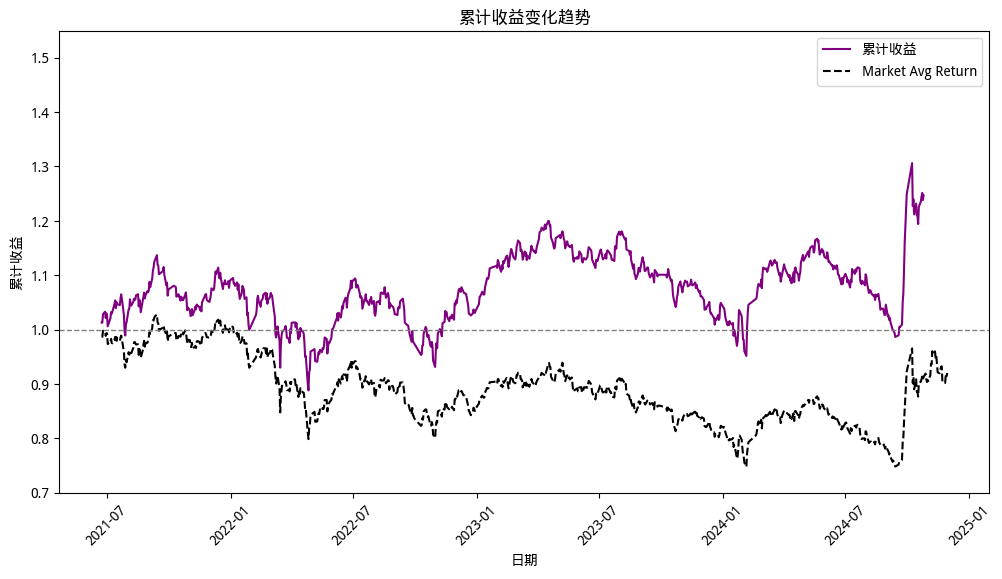

In [1210]:
# 日期转换
df["日期"] = pd.to_datetime(df["日期"])

# 转换累计收益为数值类型，删除无效值
df["累计收益"] = pd.to_numeric(df["累计收益"], errors="coerce")
df = df.dropna(subset=["累计收益"])

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(df["日期"], df["累计收益"]+1, linestyle="-", color="purple", label="累计收益")

# 对齐 market 数据
market_cumulative_returns_aligned = market_cumulative_returns.reindex(df["日期"])
plt.plot(sz300_df["交易日期"].iloc[15:], sz300_df["累计收益"].iloc[15:] + 1,
         linestyle='--', color='black', label="Market Avg Return")

plt.title("累计收益变化趋势")
plt.xlabel("日期")
plt.ylabel("累计收益")
plt.ylim(0.7, 1.55)  # 这里固定y轴范围从0.7到1.5
plt.xticks(rotation=45)
plt.legend()
plt.axhline(1, color="gray", linestyle="--", linewidth=1)

os.makedirs('长期投资/累计投资收益', exist_ok=True)
plt.savefig(f'长期投资/累计投资收益/{experiment}.png')
plt.show()


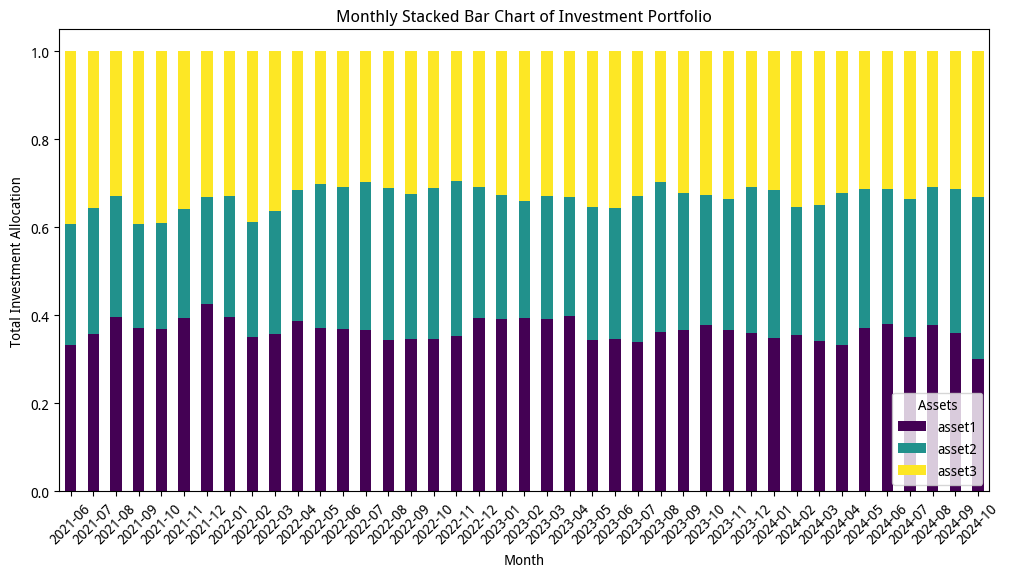

In [1211]:
# 解析日期列
df["日期"] = pd.to_datetime(df["日期"], errors="coerce")

# 处理当日投资组合列：去除方括号和空格、用逗号拆分成浮点数列表
df["当日投资组合"] = df["当日投资组合"].str.replace("[\[\]]", "", regex=True)
df["当日投资组合"] = df["当日投资组合"].apply(
    lambda x: np.array([float(i.strip()) for i in x.split(',') if i.strip() != ""])
)

# 拆分成三列
df[["asset1", "asset2", "asset3"]] = pd.DataFrame(df["当日投资组合"].tolist(), index=df.index)

# 按月份进行汇总（这里取每月的 **总和**，也可以改成 `.mean()` 计算每月均值）
df["月份"] = df["日期"].dt.to_period("M")  # 转换为月份
monthly_data = df.groupby("月份")[["asset1", "asset2", "asset3"]].mean()  # 计算每月资产总额

# 绘制堆积柱状图
monthly_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

# 美化图表
plt.xlabel("Month")
plt.ylabel("Total Investment Allocation")
plt.title("Monthly Stacked Bar Chart of Investment Portfolio")
plt.legend(title="Assets", loc="lower right")
plt.xticks(rotation=45)

# 显示图表
os.makedirs('长期投资/投资组合', exist_ok=True)
plt.savefig(f'长期投资/投资组合/{experiment}.png')
plt.show()